## How long per day are the lights in the living room on? Is there any pattern during the year? Does rain play a role ?

###  Description :

 
We have data of messages collected from many smart home devices of a family house between September 2022 and April 2023.  The devices include: sockets, wall switches, light bulbs, temperature/humidity sensors etc. They generate daily more than 1000 messages about their state (e.g. "current temperature is 20.1°C", "the light has been turned on", "the door has been opened", "motion has been detected", etc.). Moreover, we have access to weather data, including temperature, wind speed, rainfall, and other relevant meteorological variables, which may influence energy usage.

In this report, we are mainly interested in lights  in the livig room only their 'switch' messages, which has a value of 'on' or 'off'. We will calculate the daily duration when lights are 'on' and see if there are any differences or patterns during the year. Lastly, we will see if rain had played a role in the mean daily duration of switching lights. 

### Data Preparation :

In [1]:
import sys
import os
import warnings
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, DateFormatter

sys.path.append('../')  # Add the parent directory to the system path

from tools.openweather import openweather_data
from tools.home_messages_db  import *

openweather_data=openweather_data.copy()
db_url = f'sqlite:///{os.path.join(os.path.dirname(os.getcwd()), "myhome.db")}'
db = home_messages_db(url = db_url)
#This query will get us all messages of living room lights where the attribute is 'switch'
query = """
WITH dev_utils AS (SELECT * FROM devices WHERE label LIKE '%Light%' OR label LIKE '%light%')
SELECT message_id, time, attribute, value, m.device_id, source_id
FROM messages m JOIN dev_utils d ON m.device_id = d.device_id
WHERE location = 'living room' AND attribute LIKE '%switch%'
ORDER BY time, message_id, source_id
"""
living_lights_switch = db.query_df(query)
warnings.filterwarnings('ignore')

To calculate the interval for each switch, we will create a new column 'time2' where it will be negative if the value is 'on' and positive otherwise. On each day, the total duration of all lights will be the sum of this newly defind column.
The idea behind this approach is that, the duration for each device, at each time that device was used, equals the value of the time when the device was off and minus the value of the time when the device was on. Since both times are in seconds, the difference will also be in seconds.

In [2]:
living_lights_switch['time2'] = living_lights_switch['time'].astype(int) 
living_lights_switch.loc[living_lights_switch['value'] == 'on', 'time2'] *= -1
#adding a new column : day and date : we will group by them later :
living_lights_switch['day'] = pd.to_datetime(living_lights_switch['time'], unit='s', origin='unix').dt.date
living_lights_switch['date'] = pd.to_datetime(living_lights_switch['time'], unit='s', origin='unix') 
#now sorting it according to day and  the device   : 
living_lights_switch = living_lights_switch.sort_values(['day', 'device_id'])

Now we will create a new dataframe, each row will represent a day, the sum of time2 column will represent the total duration when lights were on : 

In [3]:
sum_time_per_day = living_lights_switch.groupby('day')['time2'].sum().reset_index()
sum_time_per_day.columns = ['day', 'duration per day']
sum_time_per_day.describe ()

,duration per day
count,1.600000e+02
mean,2.081413e+07
std,8.608785e+08
min,-5.038824e+09
25%,1.497675e+04
50%,2.579350e+04
75%,4.040250e+04
max,5.039406e+09


We have some negative values in he sum column, this was because some mistakes in the data : Examples of such mistakes are : 
- Some devices has two consequent 'on' values, normally each 'on' should be followed by an 'off'.
- At some days, some devices has 'on' and don't have 'off'. 

Handling those cases : 


In [4]:
last_rows = living_lights_switch.groupby(['day', 'device_id']).tail(1)  # Get the last row for each group
#getting on rows which are last in the day:
last_row_on = last_rows[last_rows['value'] == 'on'].copy()
# # Remove the identified rows from the original DataFrame and store them in a new DataFrame
living_lights_switch = living_lights_switch[~living_lights_switch.index.isin(last_row_on.index)].copy()
#now we will eliminate handle cases of 2 consequative on :
living_lights_switch = living_lights_switch[(living_lights_switch['value'] != living_lights_switch['value'].shift()) | (living_lights_switch['value'] == 'off')]
#rows with off without on  :
mask = (living_lights_switch['value'] == 'off') & (living_lights_switch['value'].shift() != 'on')
# Remove the identified rows from the DataFrame
living_lights_switch = living_lights_switch[~mask]

sum_time_per_day = living_lights_switch.groupby('day')['time2'].sum().reset_index()
# # Rename the columns
sum_time_per_day.columns = ['day', 'duration per day']
#convert to hours :
sum_time_per_day [ 'duration per day']  = sum_time_per_day [ 'duration per day']  / 3600
sum_time_per_day['day'] = pd.to_datetime(sum_time_per_day['day'])
sum_time_per_day.describe ()

,duration per day
count,159.000000
mean,7.598073
std,4.337086
min,0.189722
25%,4.461667
50%,7.123611
75%,10.329861
max,24.525278


After handling some mistakes in the data, we can now get the first insights:
First of all, it might seem a bit counterintuitive that one day has 24.5 hours of lights on. However, it is totally acceptable. To explain, since we have several lights, if all were on during that day, the total duration will be 24* number of lights

The mean daily duration of switching lights in the living room is ~ 7.6 hours and the median is ~ 7.1 hours. This difference indicate that the duration of the light turned on is not well distributed and the standard deviation of ~ 4.3 hours as well as the 25 and 75 % quantiles of ~ 4.5 hours and ~ 10.3 hours show that there is a lot variaty in the duration of the light turned on.

In [5]:
def filter_by_date_range(start_date, end_date):
   """Takes two dates as input, filter the df sum_time_per_day 
   and return a new df within the time frame """
      
   start_date = pd.to_datetime(start_date)
   end_date = pd.to_datetime(end_date)

   # Convert 'day' column to datetime
   sum_time_per_day['day'] = pd.to_datetime(sum_time_per_day['day'])
   # Filter the DataFrame based on the date range
   filtered_df = sum_time_per_day[(sum_time_per_day['day'] >= start_date) & (sum_time_per_day['day'] <= end_date)]
   
   filtered_df['day'] = pd.to_datetime(filtered_df['day'])

   return filtered_df

### Plotting the data :

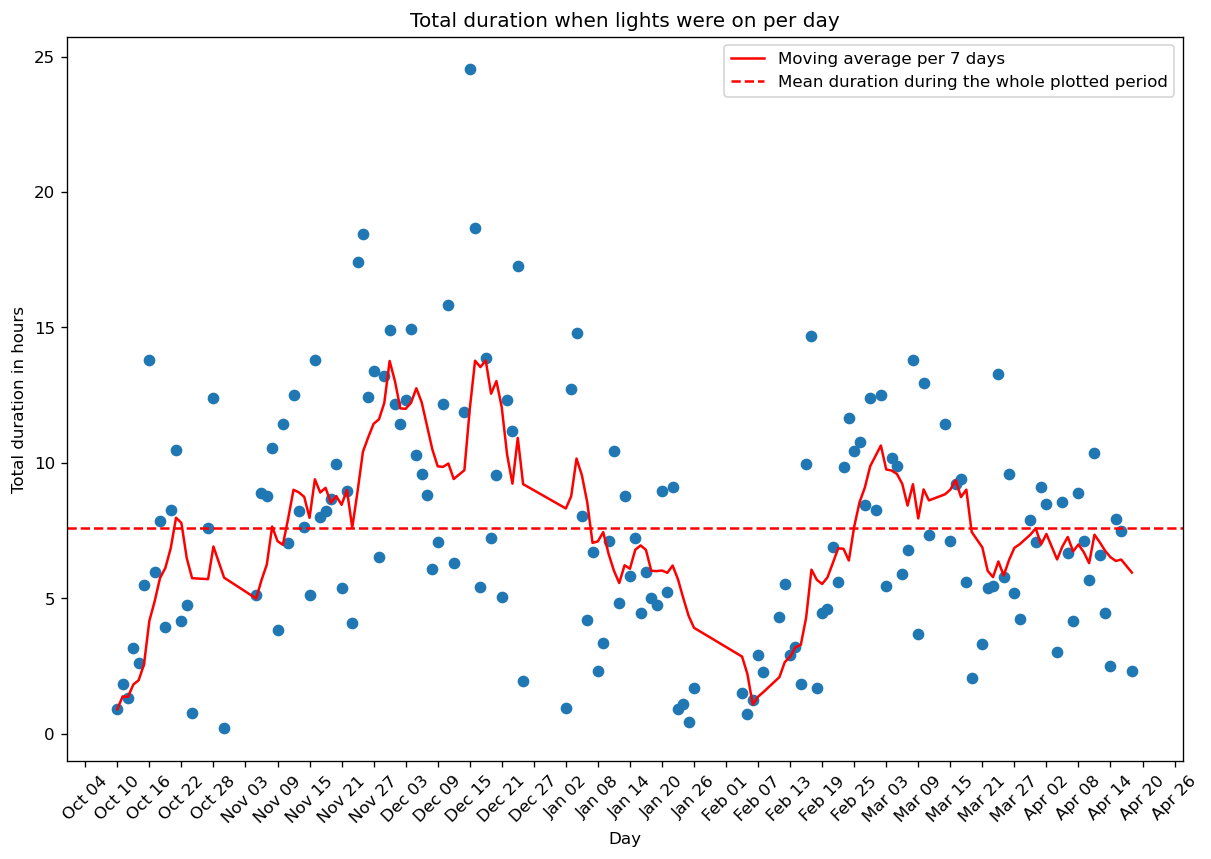

In [6]:
import numpy as np

def plot_data(sum_per_day):
    """ Takes a dataframe with two columns: one for day and the other for total duration
    per that day, and plots it"""
    plt.figure(figsize=(12, 8), dpi=120)
    plt.style.use('default')

    # Plot the data as a scatter plot
    plt.scatter(sum_per_day['day'], sum_per_day['duration per day'])
    
    # Calculate the moving average
    window_size = 7  
    moving_avg = sum_per_day['duration per day'].rolling(window_size, min_periods=1).mean()
    
    # Plot the moving average as a line
    plt.plot(sum_per_day['day'], moving_avg, color='red', label='Moving average per 7 days')
    plt.xlabel('Day')
    plt.xticks(rotation=45)
    plt.ylabel('Total duration in hours')
    plt.title('Total duration when lights were on per day')
    
    mean_time2 = sum_per_day['duration per day'].mean()
    plt.axhline(y=mean_time2, color='red', linestyle='--', label='Mean duration during the whole plotted period')
    plt.legend()    
    plt.gca().tick_params(axis='x')
    plt.gca().tick_params(axis='y')    
    # Editing the frequency of ticks on the x-axis
    locator = DayLocator(interval=6)
    formatter = DateFormatter('%b %d')
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)

    plt.show()


plot_data(sum_time_per_day)


Now let's see the duration per month : 

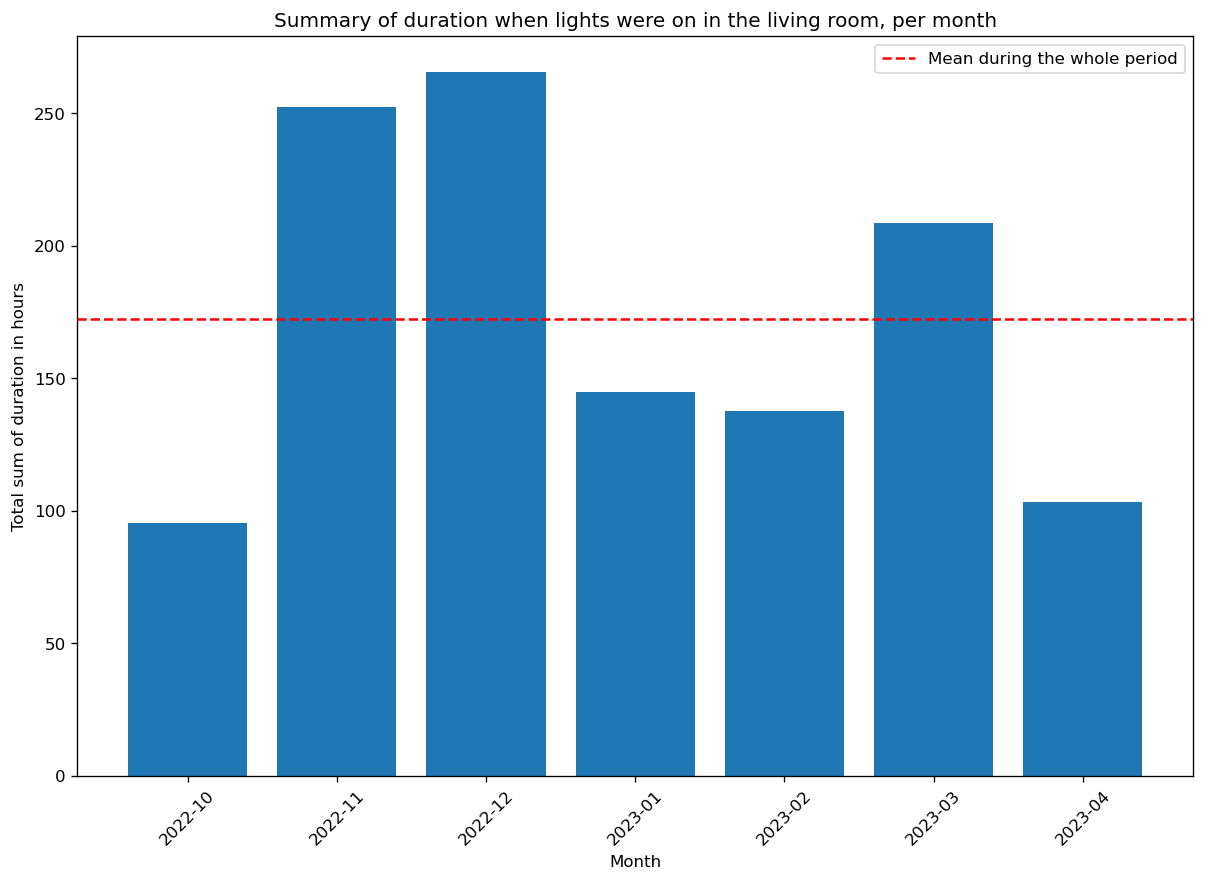

In [7]:
#Adding a new column 'month' to group by it later :
sum_time_per_day['month'] = pd.to_datetime(sum_time_per_day['day']).dt.to_period('M')
# Group the data by month and calculate the sum of 'duration per day'
sum_time_per_month = sum_time_per_day.groupby('month')['duration per day'].sum()
plt.figure(figsize=(12, 8), dpi=120)

plt.bar(sum_time_per_month.index.astype(str), sum_time_per_month)
plt.xlabel('Month' )
plt.ylabel('Total sum of duration in hours')
plt.title('Summary of duration when lights were on in the living room, per month')
plt.gca().tick_params(axis='x' )
plt.gca().tick_params(axis='y' )
plt.xticks(rotation=45)
mean_value = sum_time_per_month.mean()
plt.axhline(mean_value, color='red', linestyle='--', label='Mean during the whole period')
plt.legend( )
# Display the plot
plt.show()


Longest durations were in November and December, followed by March of the next year. In those three months duration was higher than the mean of the whole period.  
Surprisngly, January and Febreuary had lower duration than the mean.

Now, we want to see if rainfalls has a similar pattern to switching lights. On rainy days, it is more likely to stay inside. Not only because one would not do any outdoor activity, but also it might be more likely to e.g. do homeoffice. Furthermore, there will be more clouds on a rainy day and thus making the overall daylight less intense.

Because our weather data overlaps with the messages data only for about 4 months, we will not  be able to see the complete picture. We will try to spot any patterns though.

In [8]:
openweather_data['day'] = pd.to_datetime(openweather_data['time'], unit='s', origin='unix').dt.date
grouped_day_rain= openweather_data.groupby('day')['rain'].sum()
grouped_day_rain = pd.DataFrame({'day': grouped_day_rain.index, 'rain': grouped_day_rain.values})
grouped_day_rain['day'] = pd.to_datetime(grouped_day_rain['day'])
#now we will merge the two dataframes 
# so that each row is a day which has two values, the duration of lights
#and the rainfall
merged_rain_lights = pd.merge(grouped_day_rain, sum_time_per_day, on='day')
 

Let's plot the data for both rainfalls and lights duration :

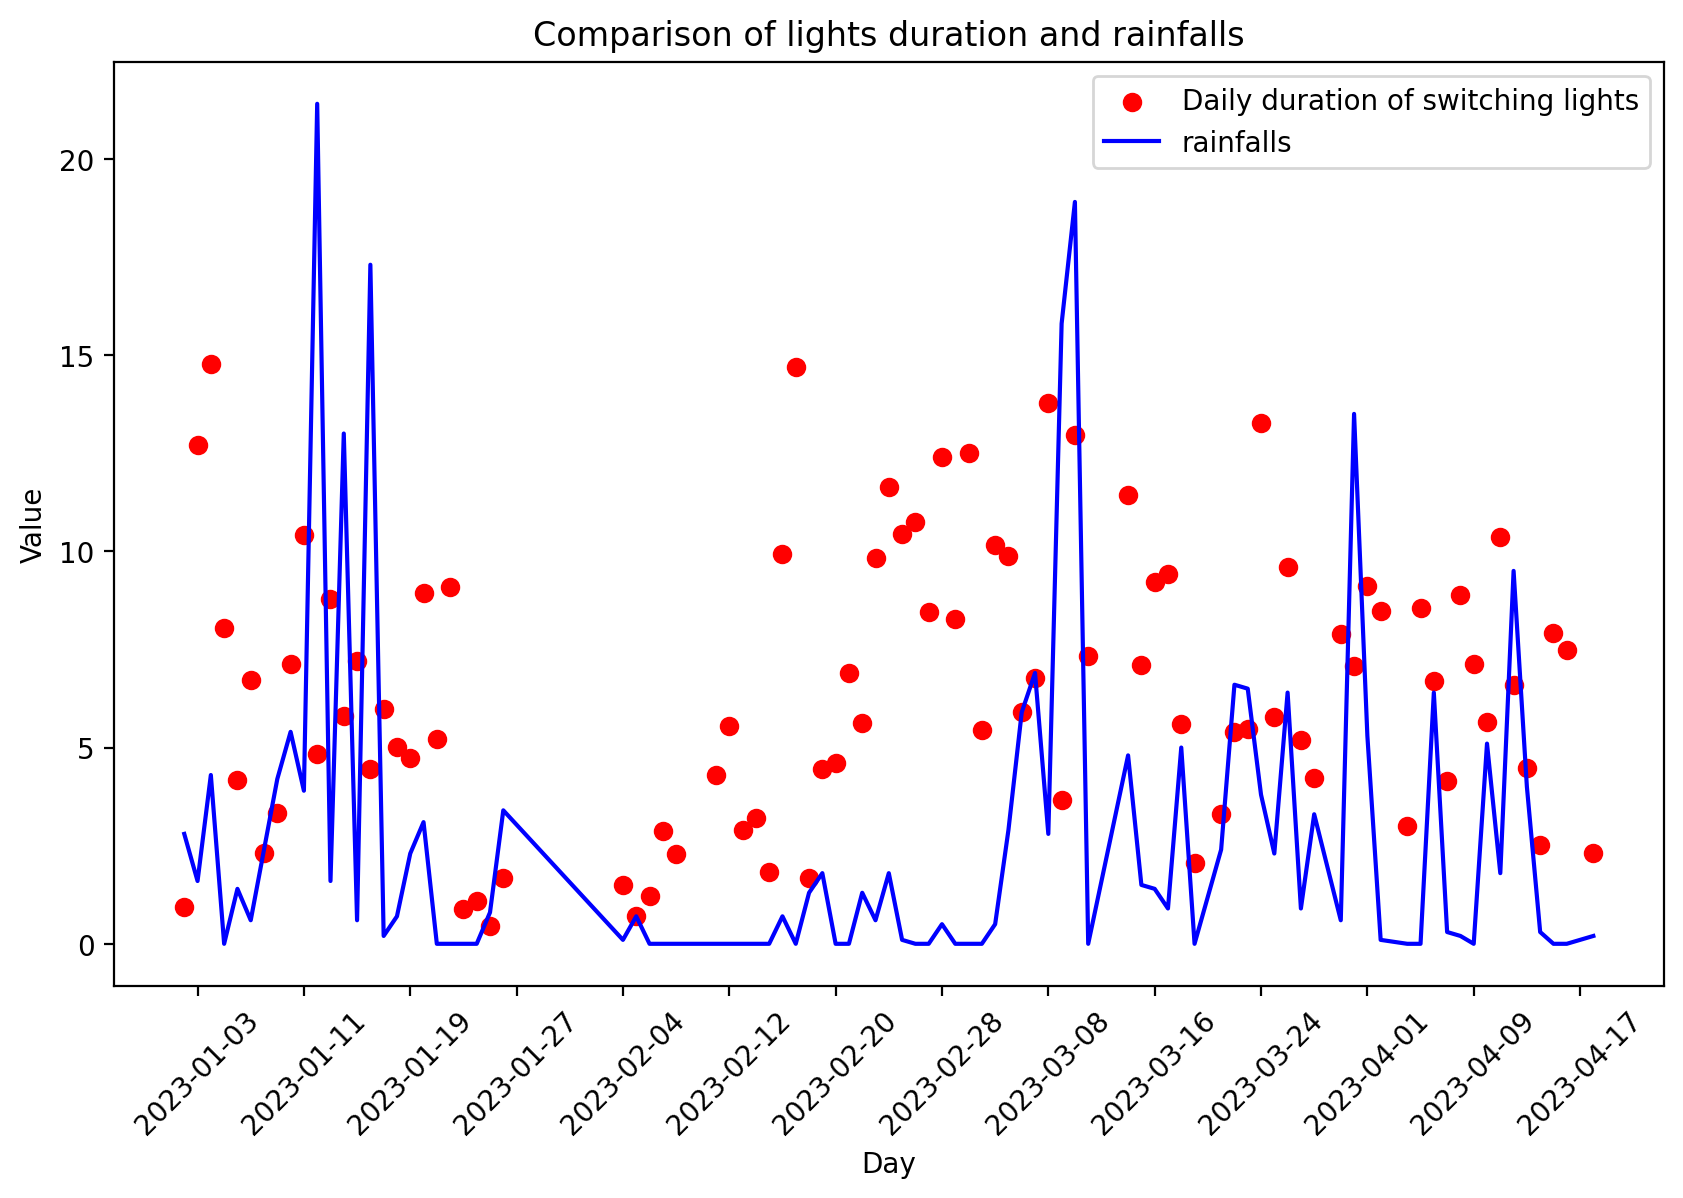

In [9]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.scatter(merged_rain_lights['day'], merged_rain_lights['duration per day'], color='red', label='Daily duration of switching lights')
# Plot rain as a line plot
ax.plot(merged_rain_lights['day'], merged_rain_lights['rain'], color='blue', label='rainfalls')
ax.set_xlabel('Day')
ax.set_ylabel('Value')
ax.set_title('Comparison of lights duration and rainfalls')
ax.tick_params(axis='x', rotation=45)
# Set x-tick frequency 
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.legend()
plt.show()

Although the overlapping period is relatively short, we can spot a fairly weak pattern, higher rainfalls seem to be more associated with higher durations of using lights in the livig room. The pattern is not consistant though.

To better understand any existing patterns, we will plot the total lights duration per week with the rainfalls during that week : 

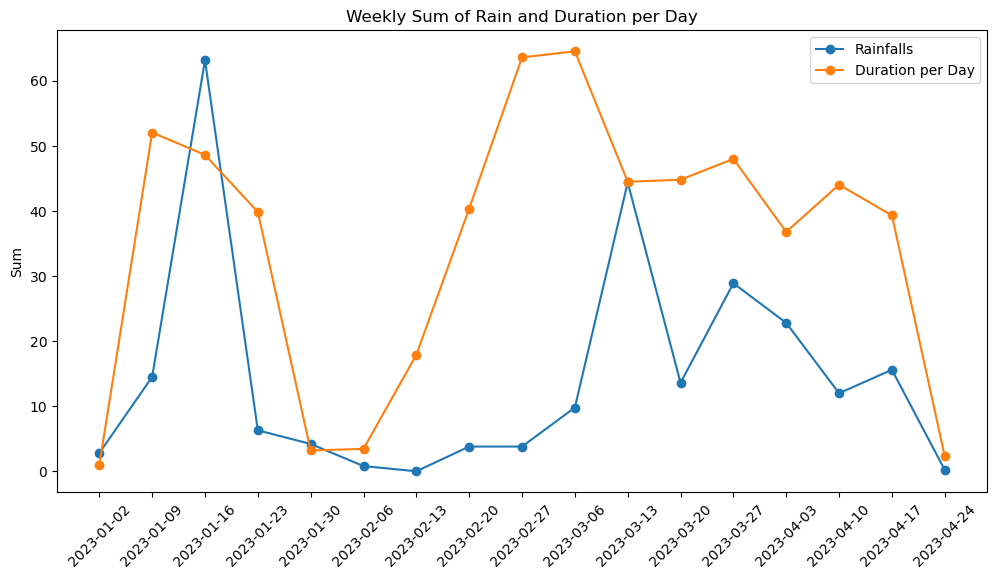

In [10]:
merged_rain_lights['day'] = pd.to_datetime(merged_rain_lights['day'])
# Group the data by week and calculate the sums
weekly_sum = merged_rain_lights.groupby(pd.Grouper(key='day', freq='W-MON')).sum()
# Create a single line plot
fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(weekly_sum))
# Plot the line for sum of rain
ax.plot(x, weekly_sum['rain'], label='Rainfalls', marker='o')
# Plot the line for sum of duration per day
ax.plot(x, weekly_sum['duration per day'], label='Duration per Day', marker='o')

ax.set_xticks(x)
ax.set_xticklabels(weekly_sum.index.strftime('%Y-%m-%d'))
ax.set_ylabel('Sum')

ax.set_title('Weekly Sum of Rain and Duration per Day')
ax.legend()
ax.tick_params(axis='x', rotation=45)
plt.show()

The association between lights duration and rainfalls seems to be more obvious now. Again, the pattern is weak and not consistant ( especially during February).